### Session Trend Analysis

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import seaborn as sns
from collections import Counter

In [14]:
# Load the session lengths data
df = pd.read_csv('session_lengths.csv')

# Convert session_start to datetime
df['session_start'] = pd.to_datetime(df['session_start'])

# Group by study_week and calculate metrics
weekly = df.groupby('study_week').agg(
    avg_session_duration_sec=('session_duration_sec', 'mean'),
    session_count=('session_id', 'count')
).reset_index()

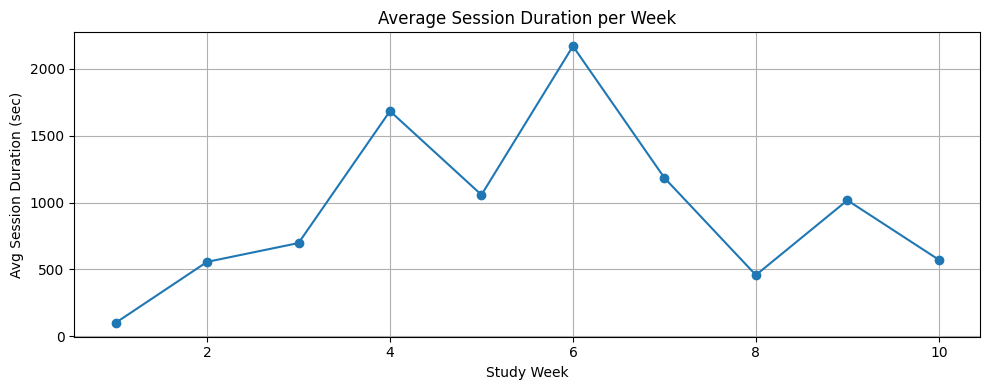

In [15]:
# Plot average session duration per week
plt.figure(figsize=(10,4))
plt.plot(weekly['study_week'], weekly['avg_session_duration_sec'], marker='o')
plt.title('Average Session Duration per Week')
plt.xlabel('Study Week')
plt.ylabel('Avg Session Duration (sec)')
plt.grid(True)
plt.tight_layout()
plt.show()

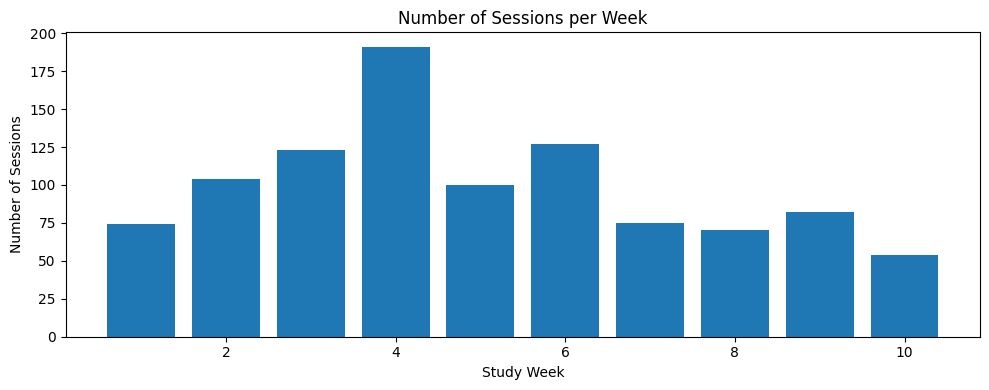

In [16]:
# Plot number of sessions per week
plt.figure(figsize=(10,4))
plt.bar(weekly['study_week'], weekly['session_count'])
plt.title('Number of Sessions per Week')
plt.xlabel('Study Week')
plt.ylabel('Number of Sessions')
plt.tight_layout()
plt.show()

### Active Users Per Week

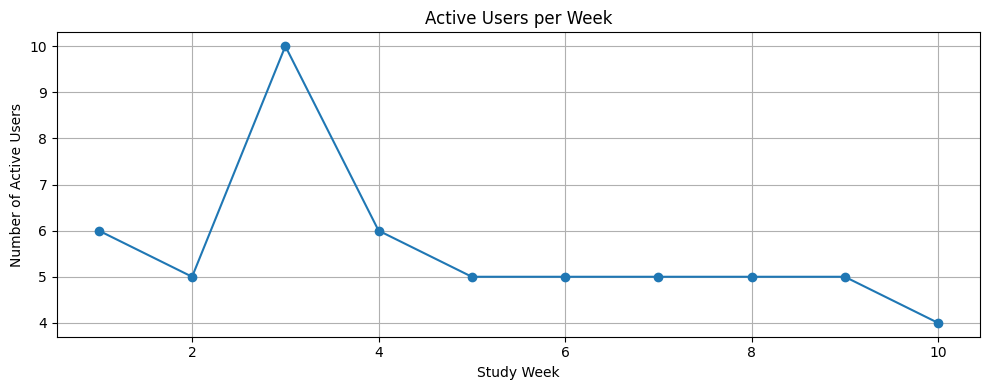

In [17]:
active_users = df.groupby('study_week')['userid'].nunique().reset_index()
plt.figure(figsize=(10,4))
plt.plot(active_users['study_week'], active_users['userid'], marker='o')
plt.title('Active Users per Week')
plt.xlabel('Study Week')
plt.ylabel('Number of Active Users')
plt.grid(True)
plt.tight_layout()
plt.show()

# Session Duration Distribution

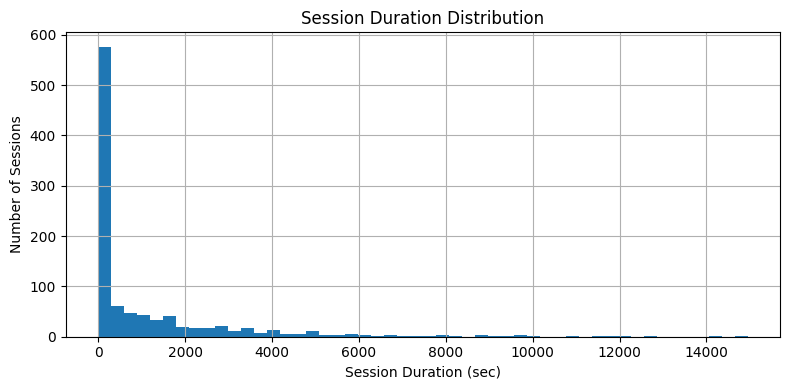

In [18]:
plt.figure(figsize=(8,4))
df['session_duration_sec'].hist(bins=50)
plt.title('Session Duration Distribution')
plt.xlabel('Session Duration (sec)')
plt.ylabel('Number of Sessions')
plt.tight_layout()
plt.show()

# Session Trends by course
### 3547 - SP1
### 3653 - SP3

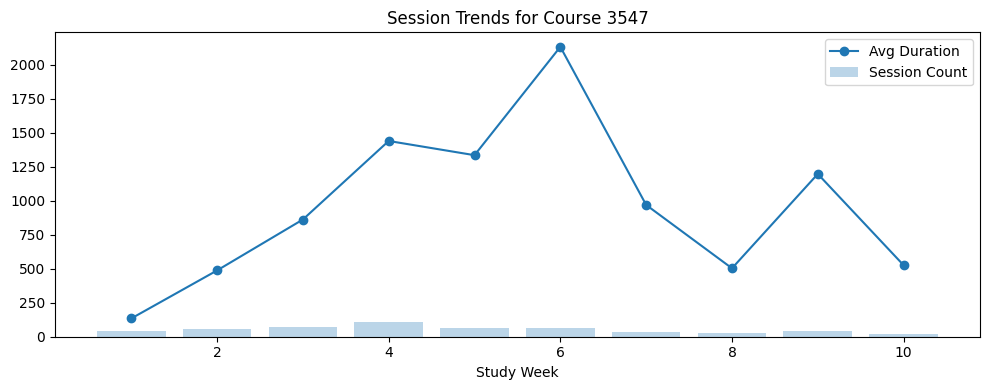

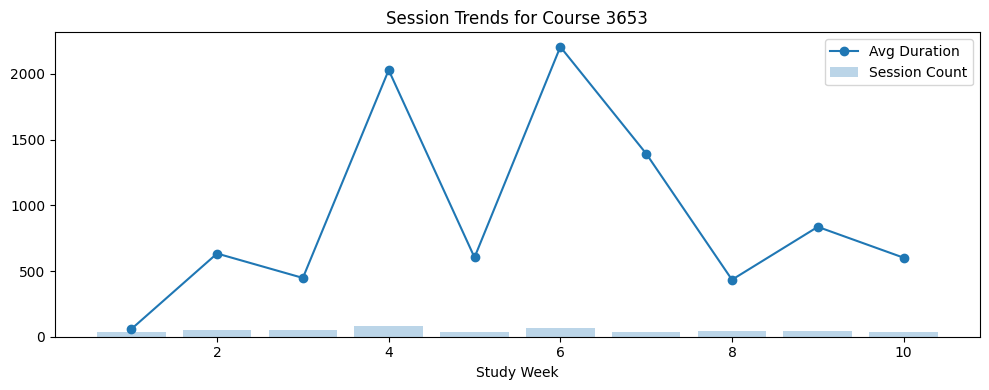

In [19]:
course_week = df.groupby(['course', 'study_week']).agg(
    avg_session_duration_sec=('session_duration_sec', 'mean'),
    session_count=('session_id', 'count')
).reset_index()
for course in course_week['course'].unique():
    subset = course_week[course_week['course'] == course]
    plt.figure(figsize=(10,4))
    plt.plot(subset['study_week'], subset['avg_session_duration_sec'], marker='o', label='Avg Duration')
    plt.bar(subset['study_week'], subset['session_count'], alpha=0.3, label='Session Count')
    plt.title(f'Session Trends for Course {course}')
    plt.xlabel('Study Week')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Returning vs New users

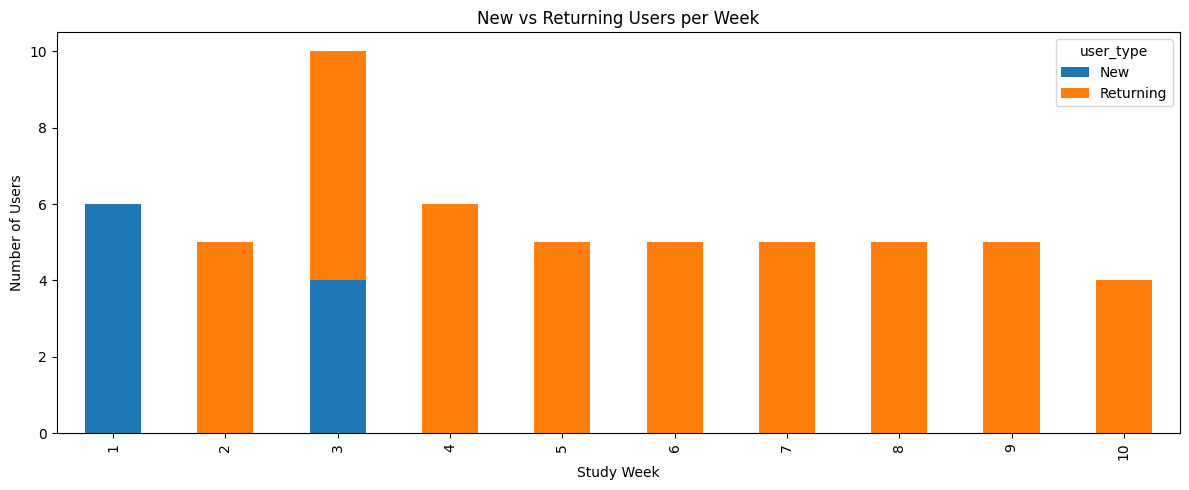

In [20]:
df = df.sort_values(['userid', 'session_start'])
df['first_session_week'] = df.groupby('userid')['study_week'].transform('min')
df['user_type'] = np.where(df['study_week'] == df['first_session_week'], 'New', 'Returning')
user_type_week = df.groupby(['study_week', 'user_type'])['userid'].nunique().unstack(fill_value=0)
user_type_week.plot(kind='bar', stacked=True, figsize=(12,5))
plt.title('New vs Returning Users per Week')
plt.xlabel('Study Week')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

# Session Start Time Analysis

In [21]:
def time_bucket(hour):
    if 0 <= hour <= 5:
        return 'Early Morning'
    elif 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour <= 21:
        return 'Evening'
    else:  # 22 <= hour <= 24
        return 'Night (Late)'

df['hour'] = df['session_start'].dt.hour
df['time_bucket'] = df['hour'].apply(time_bucket)

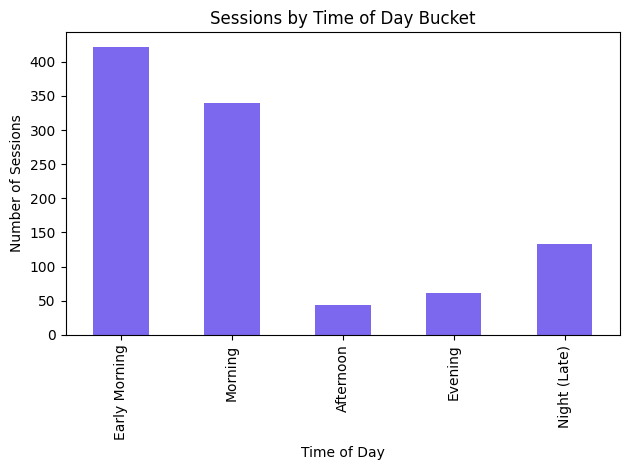

In [22]:
bucket_order = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night (Late)']
time_bucket_counts = df['time_bucket'].value_counts().reindex(bucket_order)
time_bucket_counts.plot(kind='bar', color='mediumslateblue')
plt.title('Sessions by Time of Day Bucket')
plt.xlabel('Time of Day')
plt.ylabel('Number of Sessions')
plt.tight_layout()
plt.show()

# Session Gaps (time between sessions for each user)

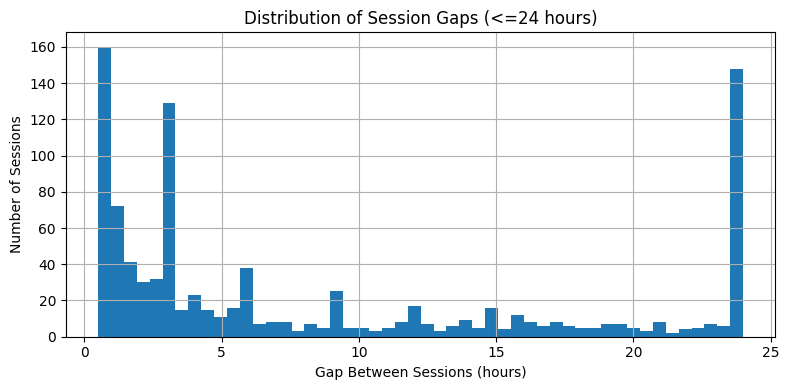

In [25]:

df = df.sort_values(['userid', 'session_start'])
df['prev_session_end'] = df.groupby('userid')['session_end'].shift(1)
df['prev_session_end'] = pd.to_datetime(df['prev_session_end'])
df['gap_hours'] = (df['session_start'] - df['prev_session_end']).dt.total_seconds() / 3600
plt.figure(figsize=(8,4))
df['gap_hours'].dropna().clip(upper=24).hist(bins=50)
plt.title('Distribution of Session Gaps (<=24 hours)')
plt.xlabel('Gap Between Sessions (hours)')
plt.ylabel('Number of Sessions')
plt.tight_layout()
plt.show()

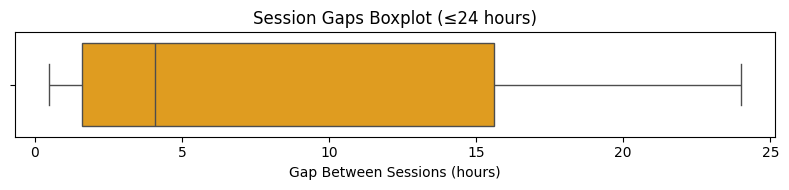

In [27]:
# Boxplot (for outlier detection)
plt.figure(figsize=(8,2))
sns.boxplot(x=df['gap_hours'].dropna().clip(upper=24), color='orange')
plt.title('Session Gaps Boxplot (≤24 hours)')
plt.xlabel('Gap Between Sessions (hours)')
plt.tight_layout()
plt.show()

### Interpretation
The line inside the box (around 4 hours) shows that half of the session gaps are less than this value. This means users typically return for another session within about 4 hours.

Most users return for another session within a few hours.
There is a wide spread in session gaps, but the majority are under 15 hours.
A significant portion of users return within the same day, with a smaller number waiting close to a full day


In [ ]:
gaps = df['gap_hours'].dropna()
print('Session Gap Summary (hours):')
print(gaps.describe(percentiles=[.25, .5, .75, .9, .95, .99]))

Session Gap Summary (hours):
count    990.000000
mean      16.240313
std       51.138406
min        0.500833
25%        1.603819
50%        4.081250
75%       15.620694
90%       36.209750
95%       51.065292
99%      142.305772
max      782.729722
Name: gap_hours, dtype: float64


# Forum post analysis

In [29]:
forum_df = pd.read_csv('session_forum_activity.csv')

## Forum Event Count Trend

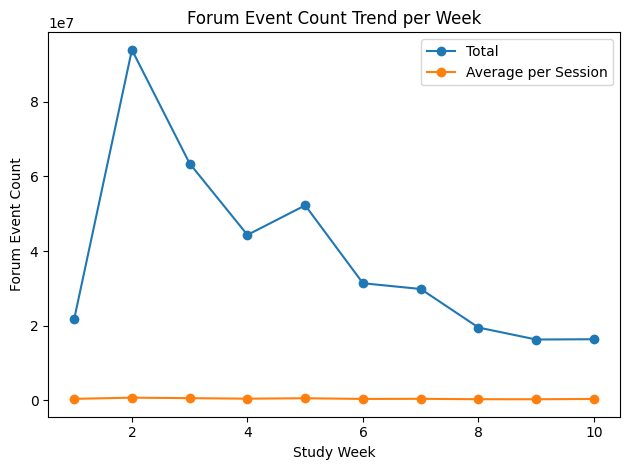

In [30]:
# Total and average forum events per week
weekly_forum = forum_df.groupby('study_week')['forum_event_count'].agg(['sum', 'mean'])
weekly_forum.plot(y=['sum', 'mean'], use_index=True, marker='o')
plt.title('Forum Event Count Trend per Week')
plt.xlabel('Study Week')
plt.ylabel('Forum Event Count')
plt.legend(['Total', 'Average per Session'])
plt.tight_layout()
plt.show()

## Distinct Forums Accessed Trend

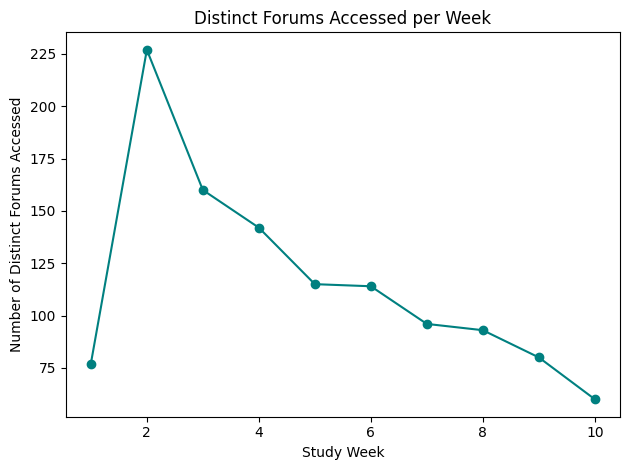

In [31]:
distinct_forums = forum_df.groupby('study_week')['distinct_forums_accessed'].sum()
distinct_forums.plot(marker='o', color='teal')
plt.title('Distinct Forums Accessed per Week')
plt.xlabel('Study Week')
plt.ylabel('Number of Distinct Forums Accessed')
plt.tight_layout()
plt.show()

## Action Type Breakdown

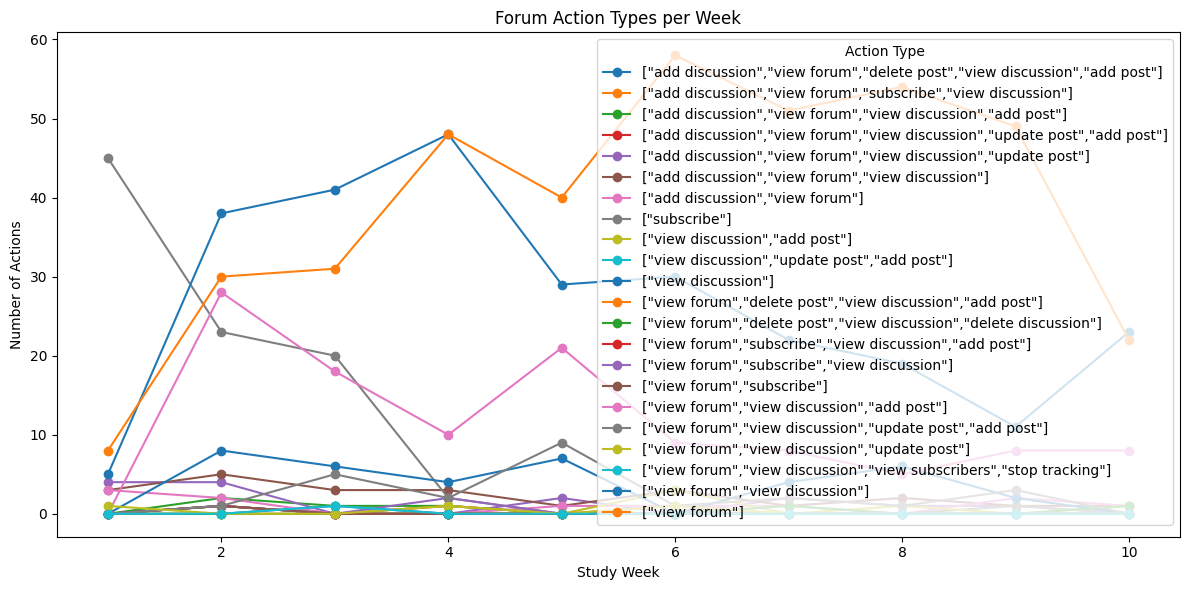

In [32]:
# Expand the dataframe so each row is a session-action pair
expanded = forum_df.copy()
expanded = expanded.explode('action_types')

# Count action types per week
action_week = expanded.groupby(['study_week', 'action_types']).size().unstack(fill_value=0)

action_week.plot(kind='line', marker='o', figsize=(12,6))
plt.title('Forum Action Types per Week')
plt.xlabel('Study Week')
plt.ylabel('Number of Actions')
plt.legend(title='Action Type')
plt.tight_layout()
plt.show()

In [40]:
# Safe parsing of action_types column
def parse_action_types(x):
    if isinstance(x, list):
        return x
    elif pd.isnull(x):
        return []
    else:
        return ast.literal_eval(x)

forum_df['action_types'] = forum_df['action_types'].apply(parse_action_types)

# Flatten all actions to find the most common
all_actions = [action for sublist in forum_df['action_types'] for action in sublist]
action_counts = Counter(all_actions)

# Show the top 5 most common actions
top_actions = [action for action, count in action_counts.most_common(5)]
print("Top 5 actions:", top_actions)

# Expand so each row is a single action
expanded = forum_df.copy()
expanded = expanded.explode('action_types')

# Filter for only the top actions
expanded_top = expanded[expanded['action_types'].isin(top_actions)]

# Count actions per week for top actions
action_week_top = expanded_top.groupby(['study_week', 'action_types']).size().unstack(fill_value=0)

Top 5 actions: ['view forum', 'view discussion', 'add post', 'subscribe', 'add discussion']


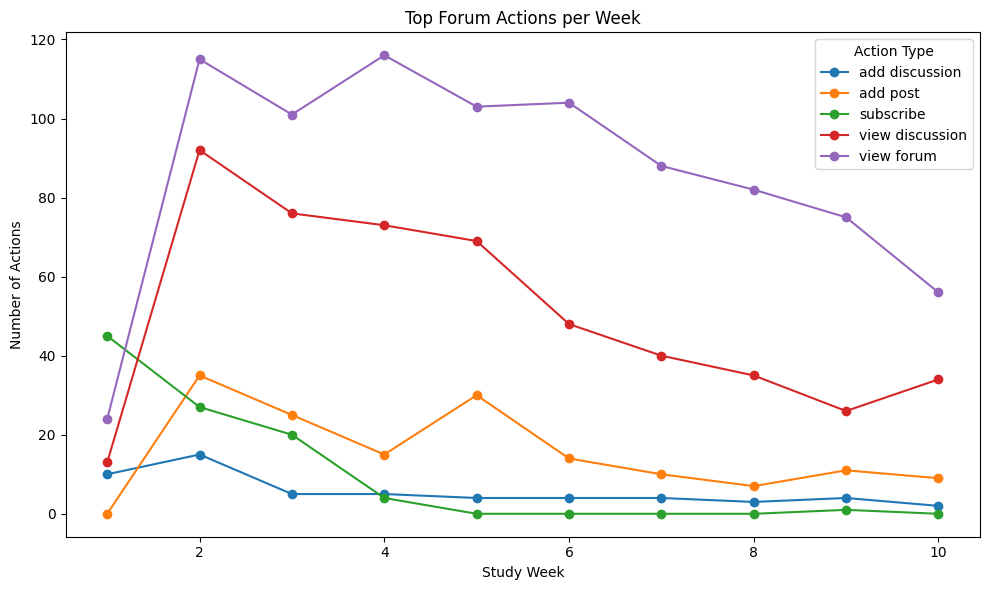

In [41]:
# Plot
action_week_top.plot(kind='line', marker='o', figsize=(10,6))
plt.title('Top Forum Actions per Week')
plt.xlabel('Study Week')
plt.ylabel('Number of Actions')
plt.legend(title='Action Type')
plt.tight_layout()
plt.show()

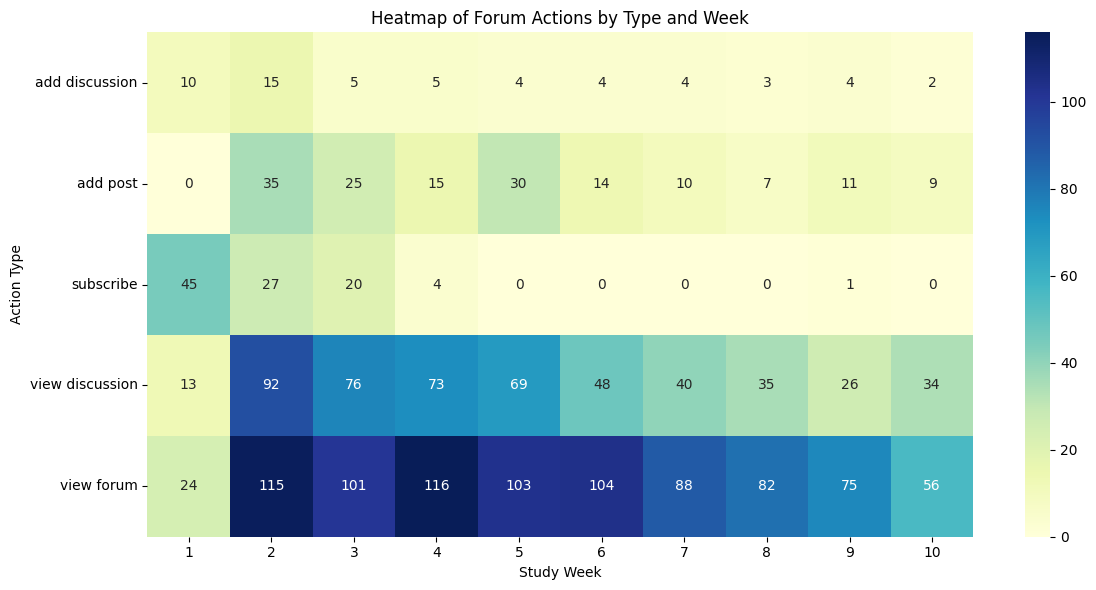

In [44]:
# Plot
plt.figure(figsize=(12,6))
sns.heatmap(action_week_top.T, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Forum Actions by Type and Week')
plt.xlabel('Study Week')
plt.ylabel('Action Type')
plt.tight_layout()
plt.show()

## User Activity Segmentation

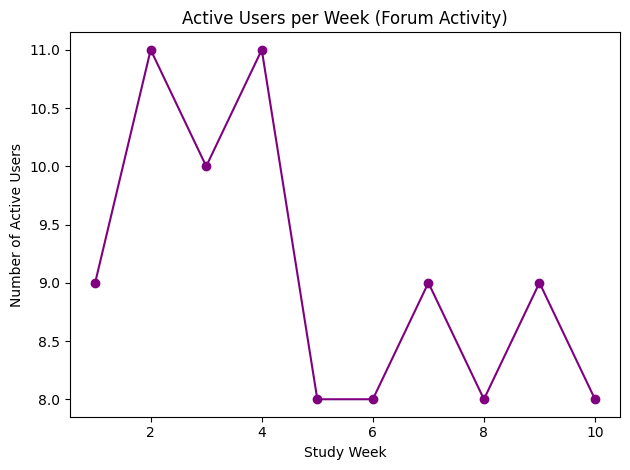

In [45]:
# Active users per week
active_users = forum_df.groupby('study_week')['userid'].nunique()
active_users.plot(marker='o', color='purple')
plt.title('Active Users per Week (Forum Activity)')
plt.xlabel('Study Week')
plt.ylabel('Number of Active Users')
plt.tight_layout()
plt.show()



## Forum Activity by Time of the Day

In [46]:
# Load both dataframes
forum_df = pd.read_csv('session_forum_activity.csv')
session_df = pd.read_csv('session_lengths.csv')

# Merge to get session_start
merged = pd.merge(forum_df, session_df[['userid', 'session_id', 'session_start']], on=['userid', 'session_id'], how='left')
merged['session_start'] = pd.to_datetime(merged['session_start'])
merged['hour'] = merged['session_start'].dt.hour

# Define time bucket function
def time_bucket(hour):
    if 0 <= hour <= 5:
        return 'Early Morning'
    elif 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour <= 21:
        return 'Evening'
    else:
        return 'Night (Late)'

merged['time_bucket'] = merged['hour'].apply(time_bucket)

# Aggregate forum events by time bucket
bucket_order = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night (Late)']
forum_by_time = merged.groupby('time_bucket')['forum_event_count'].sum().reindex(bucket_order)


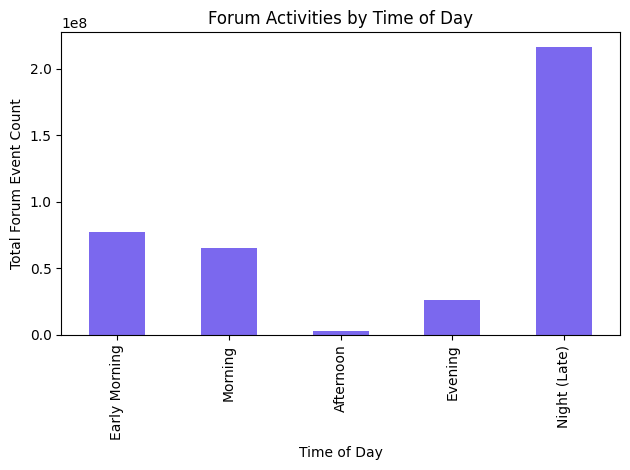

In [40]:
# Plot
forum_by_time.plot(kind='bar', color='mediumslateblue')
plt.title('Forum Activities by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Total Forum Event Count')
plt.tight_layout()
plt.show()

### Aggregate by week and time bucket

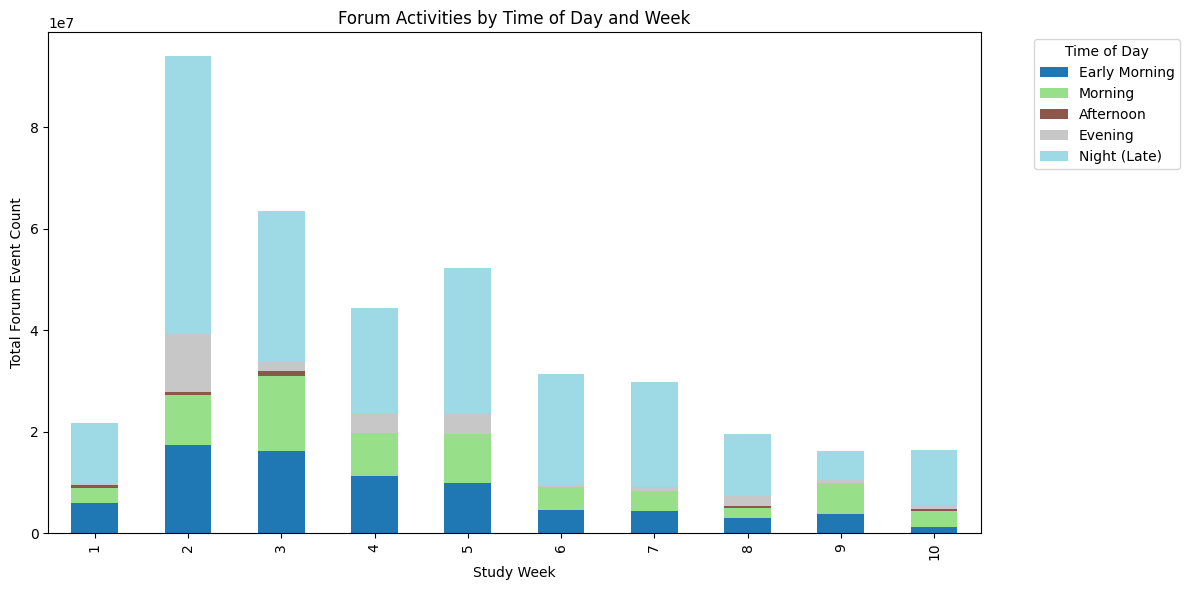

In [47]:
# Group by study_week and time_bucket, summing forum_event_count
forum_by_week_time = merged.groupby(['study_week', 'time_bucket'])['forum_event_count'].sum().unstack(fill_value=0)

# Ensure correct order of time buckets
bucket_order = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night (Late)']
forum_by_week_time = forum_by_week_time[bucket_order]

# Plot as a stacked bar chart
forum_by_week_time.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.title('Forum Activities by Time of Day and Week')
plt.xlabel('Study Week')
plt.ylabel('Total Forum Event Count')
plt.legend(title='Time of Day', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()